Things to check:
- Base map projection, ob passend zu coord sys
- Ob GDlat and Glon die richtigen Coords sind.
- Check epicentre coords
- SAMPLE RATE? (Auflösung der daten --> hardcoded atm)
- delta vtec oder vtec, tec oder los_tec?

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import os
from scipy.signal import butter, filtfilt

event_time = "2011-03-11 05:46:00"
epicentre = ((38.321944, 142.368889))
# Load and preprocess data
df = pd.read_csv('tohoku_filtered_data.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

print(df.columns)
#print(df['datetime'])

Index(['year', 'month', 'day', 'hour', 'min', 'sec', 'recno', 'kindat',
       'kinst', 'ut1_unix', 'ut2_unix', 'pierce_alt', 'gps_site', 'sat_id',
       'gnss_type', 'gdlatr', 'gdlonr', 'los_tec', 'dlos_tec', 'tec', 'azm',
       'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias'],
      dtype='object')


In [58]:
def get_filtered_df_time(df, spec_time):
    spec_time = pd.to_datetime(spec_time)
    df_filtered = df[(df.index == spec_time)]
    return df_filtered

def plot_tec_map(df, time, epicentre):

    tec_min = df['tec'].min()
    tec_max = df['tec'].max()
    
    # Define a fixed map extent [lon_min, lon_max, lat_min, lat_max]
    map_extent = [df['glon'].min() - 5, df['glon'].max() + 5, df['gdlat'].min() - 5, df['gdlat'].max() + 5]

    df_filtered = get_filtered_df_time(df, time)

    if df_filtered.empty:
        print("No data available for the specified event time.")
        return

    # Extract latitude, longitude, and TEC values for plotting
    latitudes = df_filtered['gdlat'] #GDLAT: Geodetic latitude of measurement, units: deg
    longitudes = df_filtered['glon'] #GLON: Geographic longitude of measurement, units: deg
    tec_values = df_filtered['tec'] #VTEC
    
    # Set up plot with Cartopy's Plate Carrée projection
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add basemap with country borders
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())
        
    # Scatter plot for TEC values
    scatter = plt.scatter(longitudes, latitudes, c=tec_values, cmap='jet', marker='o', vmin=tec_min, vmax=tec_max, transform=ccrs.PlateCarree())
    plt.colorbar(scatter, label='TEC Value')

    epicenter_lat, epicenter_lon = epicentre
    plt.plot(epicenter_lon, epicenter_lat, marker='*', color='black', markersize=10, transform=ccrs.PlateCarree())
    
    # Map details
    plt.xlabel('Geografic Longitude')
    plt.ylabel('Geodetic Latitude')
    plt.title(f'VTEC Map at {time}')
    plt.grid(True)
    
    # Display plot
    plt.show()
    #plot wird nicht gespeichert.



def plt_vtec_series(data, timestamp_start, timestamp_end, time_res, epicenter):
    # Ensure output directory exists
    output_dir = 'plots_spatial_patterns/vtec/'
    os.makedirs(output_dir, exist_ok=True)

    # Calculate the TEC value range for consistent color scaling
    tec_min = data['tec'].min()
    tec_max = data['tec'].max()
    
    # Define a fixed map extent [lon_min, lon_max, lat_min, lat_max]
    map_extent = [data['glon'].min() - 5, data['glon'].max() + 5, data['gdlat'].min() - 5, data['gdlat'].max() + 5]
    
    # Convert input time arguments to timedelta
    timestamp_start = pd.to_datetime(timestamp_start)
    timestamp_end = pd.to_datetime(timestamp_end)
    time_res_delta = timedelta(minutes=time_res)
    
    
    # Loop through the data in increments of `time_res` within the specified interval
    current_time = timestamp_start
    while current_time <= timestamp_end:
        # Use get_filtered_df_time to filter data for the current timestamp
        df_current = get_filtered_df_time(data, current_time)

        if df_current.empty:
            print(f"No data available for {current_time}")
            current_time += time_res_delta
            continue
        
        # Extract latitude, longitude, and TEC values for plotting
        latitudes = df_current['gdlat']
        longitudes = df_current['glon']
        tec_values = df_current['tec']
        
        # Set up plot with Cartopy's Plate Carrée projection
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add basemap with country borders
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())
        
        # Scatter plot for TEC values
        scatter = plt.scatter(longitudes, latitudes, c=tec_values, cmap='jet', marker='o', vmin=tec_min, vmax=tec_max, transform=ccrs.PlateCarree())
        plt.colorbar(scatter, label='TEC Value')
        
        # Plot a star at the specified epicenter location
        epicenter_lat, epicenter_lon = epicenter
        plt.plot(epicenter_lon, epicenter_lat, marker='*', color='black', markersize=10, transform=ccrs.PlateCarree(), label="Epicenter")
        
        # Map details
        ax.set_title(f'TEC Map at {current_time}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.gridlines(draw_labels=True)
        
        # Save the plot to the output directory
        filename = f"{current_time.strftime('%Y%m%d_%H%M%S')}_VTEC.png"
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
        plt.close()  # Close the plot to free memory
        
        # Print a message to indicate progress
        #print(f"Saved plot for {current_time} to {filename}")
        
        # Move to the next time increment
        current_time += time_res_delta


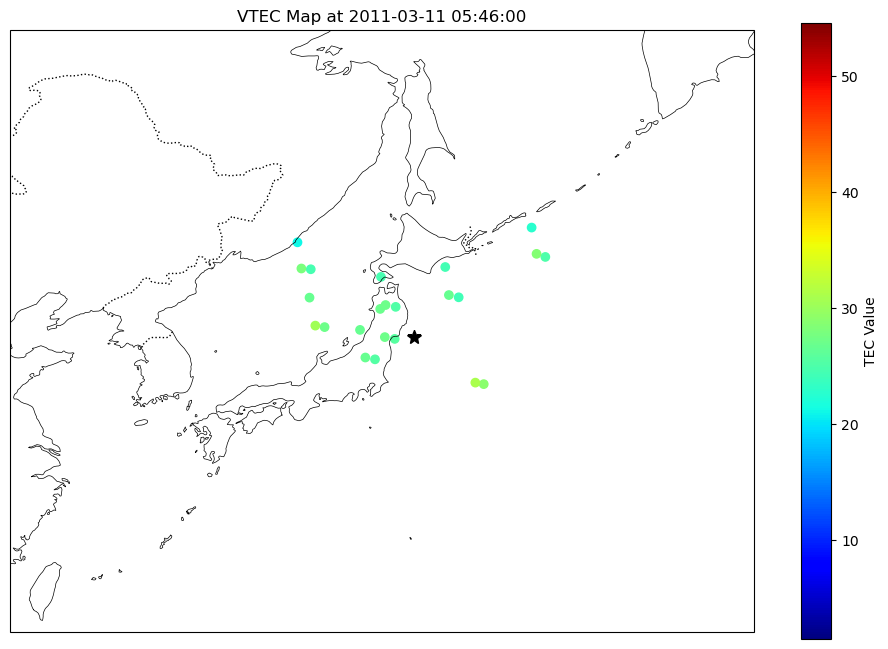

In [59]:
plot_tec_map(df, event_time, epicentre)

In [38]:
event_start = "2011-03-11 06:00:00"
event_end = "2011-03-11 06:20:00"
plt_vtec_series(df, event_start, event_end, 0.5, epicentre)
#input: csv, startzeit der plot series, zeitl aufloesung (min), anz plots (input+1), epizenter
#! achtung gleichnamige plots werden überschrieben!

No data available for 2011-03-11 06:01:00
No data available for 2011-03-11 06:03:00
No data available for 2011-03-11 06:05:30
No data available for 2011-03-11 06:07:30
No data available for 2011-03-11 06:10:00
No data available for 2011-03-11 06:12:00
No data available for 2011-03-11 06:14:30
No data available for 2011-03-11 06:16:30
No data available for 2011-03-11 06:19:00


In [46]:

#! IGNORE
"""
#function copied & altered from residuals_plus_bandfilter-3.ipynb, merci Dominik! import von function war nicht möglich, aber wär schöner... 
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def save_filtered_and_residuals_all(df, start_time, end_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec"):#, filename="df_filtered.csv"):
    """
    Creates a new CSV file with residuals and band-pass filtered data for all ground stations and satellites.
    
    Parameters:
    - df: DataFrame containing the data.
    - start_time, end_time: Start and end time for data selection.
    - lowcut, highcut: Frequency bounds for the band-pass filter.
    - tec_type: Either 'los_tec' or 'tec' to specify the column to analyze.
    #- filename: Name of the output CSV file (default is "df_filtered.csv").
    
    Returns:
    - None
    """
    # Convert time range to datetime format
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    

    # Initialize an empty DataFrame to collect all filtered data
    df_all_filtered = pd.DataFrame()

    # Loop through each unique combination of ground station and satellite
    #? glaub bi mir würs das ned bruche mit ['gps_site'] und ['sat_id'].unique()... aber naja
    for station_id in df['gps_site'].unique():
        for sat_id in df['sat_id'].unique():
            # Filter the data for the current station, satellite, and time range
            df_filtered = df[(df['gps_site'] == station_id) & 
                             (df['sat_id'] == sat_id) & 
                             (df['datetime'] >= start_time) & 
                             (df['datetime'] <= end_time)].copy()
            
            # Skip if no data is available or too few data points for filtering
            if df_filtered.empty:# or len(df_filtered) < 27:
                print(f"Skipping station {station_id}, satellite {sat_id}: insufficient data points.")
                continue
            
            # Set datetime as index
            df_filtered.set_index('datetime', inplace=True)
            
            # Calculate residuals and add as a new column
            #residuals = calculate_residuals(df_filtered[tec_type])
            #df_filtered['residuals'] = residuals
            
            # Calculate sampling interval and apply band-pass filter
            sampling_interval = (df_filtered.index[1] - df_filtered.index[0]).total_seconds() #! endtime-starttime??
            #print(df_filtered.index[1], df_filtered.index[0])
            fs = 1 / sampling_interval
            band_filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
            df_filtered['band_filtered'] = band_filtered_data
            
            # Append the filtered data with residuals and band-pass filtered data to the main DataFrame
            df_all_filtered = pd.concat([df_all_filtered, df_filtered])

    # Save the complete filtered DataFrame to a CSV file
    #df_all_filtered.to_csv(filename)

    return df_all_filtered



def plt_delta_vtec_series(df, timestamp_start, timestamp_end, time_res, lowcut, highcut, epicenter):
    #similar to function plt_delta_vtec_series but with delta_vtec (bandpass_filtered) instead
    #bandpass von dominik kopiert: thx!

    # Convert input time arguments to timedelta
    timestamp_start = pd.to_datetime(timestamp_start)
    timestamp_end = pd.to_datetime(timestamp_end)
    time_res_delta = timedelta(minutes=time_res)

    # Ensure output directory exists
    output_dir = 'plots_spatial_patterns/delta_vtec/'
    os.makedirs(output_dir, exist_ok=True)

        # Define bandpass filter parameters
    time_step = time_res * 60  # Convert time_res from minutes to seconds #? kontrolle
    fs = 1 / time_step  # Sampling frequency

    # Define map extent
    map_extent = [df['glon'].min() - 5, df['glon'].max() + 5, df['gdlat'].min() - 5, df['gdlat'].max() + 5]
    
    # Initialize color scale for filtered TEC values
    dtec_min = np.inf
    dtec_max = -np.inf

    # Loop through timestamps to determine consistent color scale
    current_time = pd.to_datetime(timestamp_start)
    timestamp_end = pd.to_datetime(timestamp_end)
    time_res_delta = timedelta(minutes=time_res)
    
    while current_time <= timestamp_end:
        df_current = get_filtered_df_time(df, current_time)
        if df_current.empty:
            current_time += time_res_delta
            continue

        # Apply bandpass filter to TEC values
        if len(df_current['tec']) > 1:  # Ensure enough data points for filtering
            df_current['band_filtered'] = bandpass_filter(
                data=df_current['tec'],
                lowcut=lowcut,
                highcut=highcut,
                fs=fs
            )
            # Update global min and max for color scale
            dtec_min = min(dtec_min, df_current['band_filtered'].min())
            dtec_max = max(dtec_max, df_current['band_filtered'].max())

        current_time += time_res_delta

    # Loop again to create the plots
    current_time = pd.to_datetime(timestamp_start)
    while current_time <= timestamp_end:
        df_current = get_filtered_df_time(df, current_time)
        if df_current.empty:
            print(f"No data available for {current_time}")
            current_time += time_res_delta
            continue

        # Apply bandpass filter to TEC values
        if len(df_current['tec']) > 1:  # Ensure enough data points for filtering
            df_current['band_filtered'] = bandpass_filter(
                data=df_current['tec'],
                lowcut=lowcut,
                highcut=highcut,
                fs=fs
            )
        
        # Extract latitude, longitude, and filtered TEC values
        latitudes = df_current['gdlat']
        longitudes = df_current['glon']
        dtec_values = df_current['band_filtered']
        
        # Set up plot with Cartopy's Plate Carrée projection
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add basemap with country borders
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())
        
        # Scatter plot for filtered TEC values
        scatter = plt.scatter(longitudes, latitudes, c=dtec_values, cmap='jet', marker='o', vmin=dtec_min, vmax=dtec_max, transform=ccrs.PlateCarree())
        plt.colorbar(scatter, label='TEC Value')
        
        # Plot a star at the specified epicenter location
        epicenter_lat, epicenter_lon = epicenter
        plt.plot(epicenter_lon, epicenter_lat, marker='*', color='black', markersize=10, transform=ccrs.PlateCarree(), label="Epicenter")
        
        # Map details
        ax.set_title(f'Delta TEC Map at {current_time}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.gridlines(draw_labels=True)
        
        # Save the plot to the output directory
        filename = f"{current_time.strftime('%Y%m%d_%H%M%S')}_delta_VTEC.png"
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
        plt.close()  # Close the plot to free memory
        
        # Print a message to indicate progress
        #print(f"Saved plot for {current_time} to {filename}")
        
        # Move to the next time increment
        current_time += time_res_delta
"""

IndentationError: unexpected indent (1620165493.py, line 15)

In [73]:
# Bandpass filter function, von Dominik!
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Data filtering and band-filter calculation
def filter_and_bandpass(data, timestamp_start, timestamp_end, lowcut, highcut, sampling_interval):
    """
    Filter data within the specified time range and apply a bandpass filter.
    Add a 'band_filtered' column to the resulting DataFrame.
    """
    # Convert timestamps to datetime
    timestamp_start = pd.to_datetime(timestamp_start)
    timestamp_end = pd.to_datetime(timestamp_end)

    # Filter data within the specified time range
    df_filtered = data[(df.index >= timestamp_start) & (df.index <= timestamp_end)]

    if df_filtered.empty:
        raise ValueError("No data available within the specified time range.")
    
    # Calculate sampling frequency
    fs = 1 / sampling_interval

    # Apply bandpass filter and add 'band_filtered' column
    filtered_data = bandpass_filter(df_filtered['tec'], lowcut, highcut, fs) #! tec oder los_tec?? > dominik hat los_tec
    df_filtered['band_filtered'] = pd.Series(filtered_data, index=df_filtered.index)

    return df_filtered

# Plotting function
def plt_delta_vtec_series(data, timestamp_start, timestamp_end, time_res, lowcut, highcut, sampling_interval, epicenter):
    """
    Plot delta TEC values as a time series for the specified time range and resolution.
    """
    # Ensure output directory exists
    output_dir = 'plots_spatial_patterns/delta_vtec/'
    os.makedirs(output_dir, exist_ok=True)

    # Filter and preprocess data
    df_filtered = filter_and_bandpass(data, timestamp_start, timestamp_end, lowcut, highcut, sampling_interval)

    # Calculate TEC value range for consistent color scaling
    dtec_min = df_filtered['band_filtered'].min()
    dtec_max = df_filtered['band_filtered'].max()

    # Define map extent
    map_extent = [df_filtered['glon'].min() - 5, df_filtered['glon'].max() + 5, df_filtered['gdlat'].min() - 5, df_filtered['gdlat'].max() + 5]

    # Time stepping
    timestamp_start = pd.to_datetime(timestamp_start)
    timestamp_end = pd.to_datetime(timestamp_end)
    time_res_delta = timedelta(minutes=time_res)

    current_time = timestamp_start
    while current_time <= timestamp_end:
        # Filter data for the current timestamp
        df_current = df_filtered[df_filtered.index == current_time]

        if df_current.empty:
            print(f"No data available for {current_time}")
            current_time += time_res_delta
            continue

        # Extract latitude, longitude, and TEC values for plotting
        latitudes = df_current['gdlat']
        longitudes = df_current['glon']
        dtec_values = df_current['band_filtered']

        # Set up plot with Cartopy's Plate Carrée projection
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Add basemap with country borders
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())

        # Scatter plot for filtered TEC values
        scatter = plt.scatter(longitudes, latitudes, c=dtec_values, cmap='jet', marker='o', vmin=dtec_min, vmax=dtec_max, transform=ccrs.PlateCarree())
        plt.colorbar(scatter, label='Delta TEC Value')

        # Plot a star at the specified epicenter location
        epicenter_lat, epicenter_lon = epicenter
        plt.plot(epicenter_lon, epicenter_lat, marker='*', color='black', markersize=10, transform=ccrs.PlateCarree(), label="Epicenter")

        # Map details
        ax.set_title(f'Delta TEC Map at {current_time}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.gridlines(draw_labels=True)

        # Save the plot to the output directory
        filename = f"{current_time.strftime('%Y%m%d_%H%M%S')}_delta_VTEC.png"
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
        plt.close()  # Close the plot to free memory

        # Print a message to indicate progress
        #print(f"Saved plot for {current_time} to {filename}")

        # Move to the next time increment
        current_time += time_res_delta

In [74]:
plt_delta_vtec_series(df, event_start, event_end, 0.5, 0.5e-3, 5e-3, 30, epicentre) #sampling rate hardcoded 30sec

/var/folders/l7/5pk7pcfn7jd6hrv8rx8jdww00000gn/T/ipykernel_1476/893163517.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['band_filtered'] = pd.Series(filtered_data, index=df_filtered.index)


No data available for 2011-03-11 06:01:00
No data available for 2011-03-11 06:03:00
No data available for 2011-03-11 06:05:30
No data available for 2011-03-11 06:07:30
No data available for 2011-03-11 06:10:00
No data available for 2011-03-11 06:12:00
No data available for 2011-03-11 06:14:30
No data available for 2011-03-11 06:16:30
No data available for 2011-03-11 06:19:00
